In [1]:
## Notebook demo bouding box-based prompt segmentation
# import library
%cd ..
import numpy as np
import matplotlib.pyplot as plt
import os 
import json
import gc
from tqdm import tqdm
from torch.utils.data.dataloader import default_collate
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from dataloader.sam_transforms import ResizeLongestSide
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import shutil
import cv2
from utils.SurfaceDice import compute_dice_coefficient
from segment_anything import our_vit
from skimage.transform import resize
import random
%cd notebook
seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cuda_string = 'cuda:' + "2"
device = torch.device(cuda_string if torch.cuda.is_available() else 'cpu')

/home/tannp/LVM-Med


/home/tannp/anaconda3/envs/usst/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/tannp/LVM-Med/notebook


In [ ]:
## Define functions for loading and preprocessing images
def preprocess(name_dataset, img, img_size, is_mask):
    # preprocess image and mask
    original_shape = img.shape
    img = np.asarray(img)
    if not is_mask:
        img = resize(img, (img_size, img_size), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
        img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
        if img.shape[-1]>3 and len(img.shape)==3:
            img = img[:,:,:3]
        if len(img.shape)==2:
            img = np.repeat(img[:,:,None], 3, axis=-1)
    else:
        img = resize(img, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
        if len(img.shape) == 3:
            img = img[:, :, 0]
    return img, original_shape

def load(filename, is_mask=False):
    # load image and mask
    if is_mask:
        mask = cv2.imread(filename, 0)
        return mask
    else:
        image = cv2.imread(filename)
        return image

In [2]:
## Define functions for drawing
def draw_bbox(image, box, label, color, thickness=3):
    # draw box for prompt
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                color, thickness)
    return overlay_bbox

def plot_img(img, size=(10, 10), is_rgb=True):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def mask_color_img(img, mask, alpha, color):
    # using overlay_image function below to draw masks into images.
    mask = np.where(mask>0)
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0)
    return(out)

def overlay_image(img_slice, mask_pred, color):
    # This function is used to draw contours and masks into images. It returns images which have masks and contours on them
    np_mask = mask_pred.copy()
    np_img = img_slice.copy()
    np_mask[np_mask > 0] = 1
    contours, hierachy = cv2.findContours(np_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour = [] 
    if len(contours) != 0:
        for i in range(0, len(contours)):
            if len(contours[i]) > len(contour):
                contour = contours[i]
    else:
        contour = contours
    color_tuple = tuple([int(x) for x in color])
    cv2.drawContours(np_img, contour, -1, color_tuple, 2);
    r = mask_color_img(np_img, np_mask, 0.25, color)
    return r

def draw_demo(out, image_demo, boxes):
    ''' mask is asigned to out variable. Through out, boxes, and image_demo, 
    this function return output which masks, contours, and boxxes are drawn on images'''
    out = resize(out, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
    image_demo = resize(image_demo, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
    image_with_masks = overlay_image(image_demo, out, color=(255,0,0))
    box = boxes.cpu().numpy()
    box[0] = int(box[0])
    box[1] = int(box[1])
    box[2] = int(box[2])
    box[3] = int(box[3])

    output = draw_bbox(image_with_masks, box, "test", (255,0,0), thickness=1)
    return output

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):
    # draw 4 images in a row
    
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i], fontdict={'fontsize': 20})
    plt.show()



In [ ]:
## Define functions for extracting predicted masks
def get_bbox_from_mask(mask):
    # Returns a bounding box from a mask
    
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - 9)
    x_max = min(W, x_max + 5)
    y_min = max(0, y_min - 9)
    y_max = min(H, y_max + 5)

    return np.array([x_min, y_min, x_max, y_max])

def process(back, sam_model, image, boxes):
    # this function is used to get the mask output of each image after using prompt to predict mask.
    with torch.no_grad():
        sam_model = sam_model.to(device)
        encoder = back.to(device)
        encoder = encoder.to("cuda:2")
        image_embedding = sam_model.preprocess(image[:, :, :])
        image_embedding = image_embedding.to("cuda:2")

        image_embedding = encoder(image_embedding)
        image_embedding = image_embedding.cpu().numpy()[0]
        image_embedding = torch.tensor(image_embedding).float()

        box_np = boxes.numpy()
        sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
        box = sam_trans.apply_boxes(box_np, (image_embedding.shape[0], image_embedding.shape[1]))
        box_torch = torch.as_tensor(box, dtype=torch.float32, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)

        """
        Prompt encoder component
        """
        prompt_encoder = sam_model.prompt_encoder.to(device)
        prompt_encoder = prompt_encoder.to(device)
        box_torch = box_torch.to(device)
        sparse_embeddings, dense_embeddings = prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )

        """
        Mask decoder component
        """
        sam_model = sam_model.to(device)
        mask_segmentation, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )
    
        out = torch.sigmoid(mask_segmentation[0, 0, :, :]).cpu().numpy().squeeze()
        out[out <= 0.5] = 0
        out[out > 0.5] = 1
    return out


In [3]:
## Run demo
def demo(dataset_name):
    # this function draw three outputs of three models and groundtruth mask
    file = "./image_demo"
    dir_image = os.path.join(os.path.join(file, dataset_name), "test")
    dir_label = os.path.join(os.path.join(file, dataset_name), "test_labels")
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    arch = 'vit_encoder_b'
    backbone = our_vit.__dict__[arch]()
    weight = torch.load('./checkpoints/vit_b_largescale_ep56.pth', map_location ='cpu')
    backbone.load_state_dict(weight)
    
    sam_model_our = sam_model_registry['vit_b'](checkpoint="./working_dir/checkpoint/sam_model_best_large_ssl_" + dataset_name + ".pth")
    sam_model_our.eval()
    backbone.eval()

    sam_model_finetune = sam_model_registry['vit_b'](checkpoint="./working_dir/checkpoint/sam_model_best_original_" + dataset_name + ".pth")
    sam_model_finetune.eval()

    sam_model_nofinetune = sam_model_registry['vit_b'](checkpoint="./working_dir/sam_vit_b_01ec64.pth")
    sam_model_nofinetune.eval()
    for i in os.listdir(dir_image):
        image_file = os.path.join(dir_image, i)
        image = load(image_file, False)
        image_demo = image.copy()
        if dataset_name == "isiconlytrain":  
            a = i.replace(".jpg", "_segmentation.png")
        else:
            a = i
        label_file = os.path.join(dir_label, a)
        label = load(label_file, True)
        label[label < 50] = 0
        label[label > 200] = 1
        label_demo = label.copy()
        
        image, original_image_shape = preprocess(dataset_name, image,  1024, is_mask=False)   # (1, 224, 224)
        label, original_mask_shape = preprocess(dataset_name, label, 1024, is_mask=True)

        boxes = get_bbox_from_mask(label)
        boxes = torch.tensor(boxes).float()
        image = torch.as_tensor(image.copy()).permute(2, 0, 1).float().contiguous()
        image = image[None, :, :, :]
        label = label[None, :, :]
        label = torch.tensor(label[None, :,:]).long()
        label = label.to("cuda:2", dtype=torch.float32)
        image = image.to("cuda:2")

        out_our = process(backbone, sam_model_our, image, boxes)
        out_finetune = process(sam_model_finetune.image_encoder, sam_model_finetune, image, boxes)
        out_nofinetune = process(sam_model_nofinetune.image_encoder, sam_model_nofinetune, image, boxes)

        a_our = compute_dice_coefficient(label.cpu()>0, out_our>0).item()*100
        a_finetune = compute_dice_coefficient(label.cpu()>0, out_finetune>0).item()*100
        a_nofinetune = compute_dice_coefficient(label.cpu()>0, out_nofinetune>0).item()*100

        output_our = draw_demo(out_our, image_demo, boxes)
        output_finetune = draw_demo(out_finetune, image_demo, boxes)
        output_nofinetune = draw_demo(out_nofinetune, image_demo, boxes)

        image_demo = resize(image_demo, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
        label_demo = resize(label_demo, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
        groundtruth = overlay_image(image_demo, label_demo, color=(255,0,0))
        
        print(i)
        titles = ["groundtruth", "LVM-Med (SAM’s ViT): dice = " + str(round(a_our, 2)), 
                  "SAM (fine-tuning): dice = " + str(round(a_finetune, 2)), "SAM (no fine-tuning): dice = " + str(round(a_nofinetune, 2))]   
        images = [cv2.cvtColor(groundtruth, cv2.COLOR_BGR2RGB), cv2.cvtColor(output_our, cv2.COLOR_BGR2RGB),
                  cv2.cvtColor(output_finetune, cv2.COLOR_BGR2RGB), cv2.cvtColor(output_nofinetune, cv2.COLOR_BGR2RGB)] 
        grid_display(images, titles, 4, (30,30))

ISIC_0001191.jpg


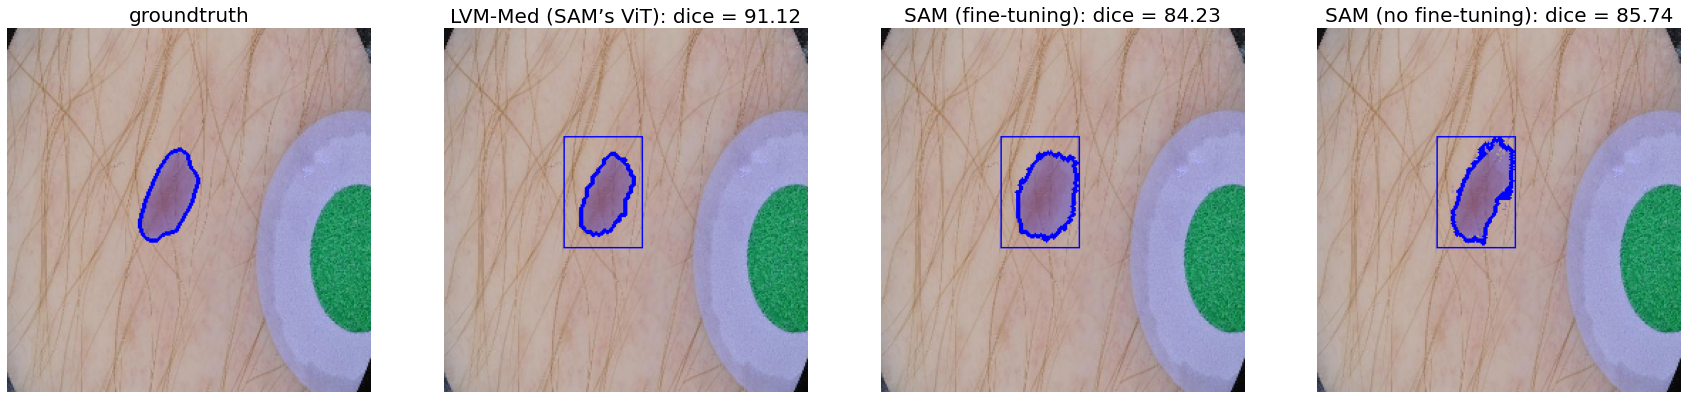

In [4]:
# Run example on ISIC dataset. First, second, third, and fourth columns are ground-truth, our LMV-Med, MedSam fined tune, and zero-shot segmentation from SAM. 
demo('isiconlytrain')

cju5xjn5mm78b09871spyqhhr.jpg


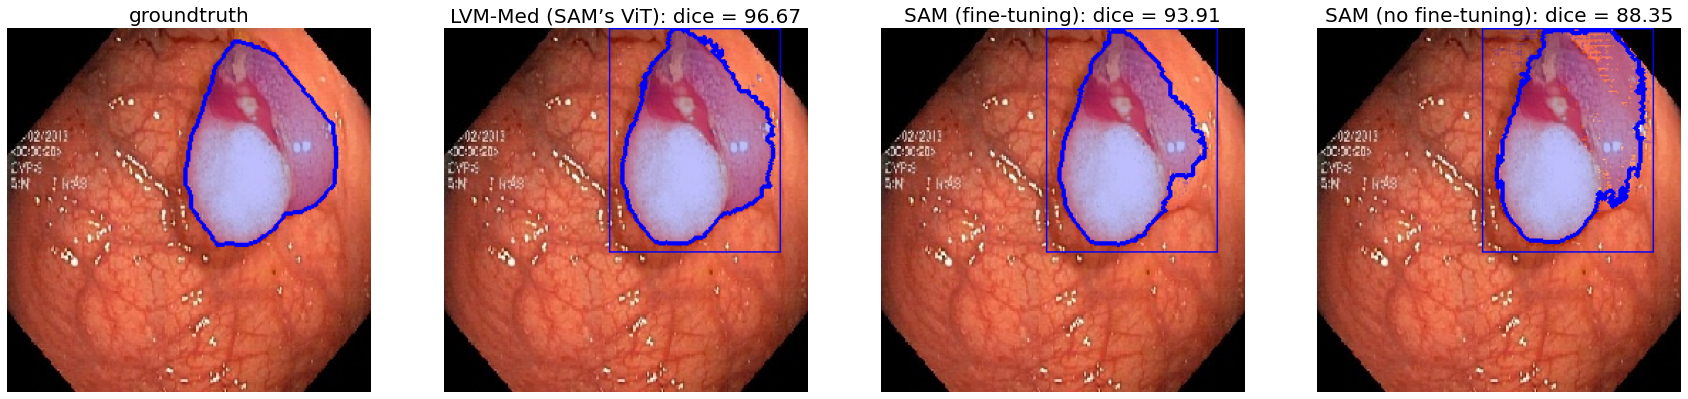

In [5]:
# Run example on Kvasir dataset. First, second, third, and fourth columns are ground-truth, our LMV-Med, MedSam fined tune, and zero-shot segmentation from SAM. 
demo("kvasir")

benign(292).png


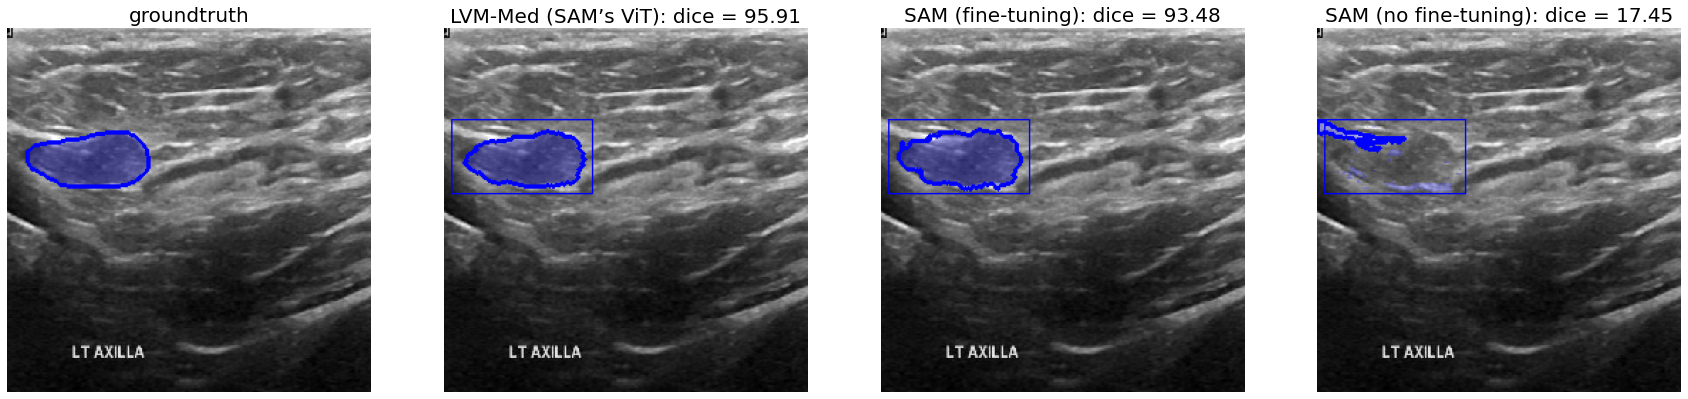

In [6]:
# Run example on BUID dataset. First, second, third, and fourth columns are ground-truth, our LMV-Med, MedSam fined tune, and zero-shot segmentation from SAM. 
demo("buidnewprocess")